**<span style="color: #808080;">In The Name of God</span>**

---

**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**

# <span style="color:rgb(143, 0, 255);">Task #1</span>
# <span style="color: #8F00FF;">**Classification**
</span>


## <span style="color: #8F00FF;">**EDA**

### <span style="color: #8F00FF;">**loading stuff**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


df = pd.read_csv('content/cancer_patients/train_data.csv')



### <span style="color: #8F00FF;">**Checking birthdate Distribution**


<img src="content\images\birthdate.png" width="2000" alt="Description">

### <span style="color: #8F00FF;">**Effect of occuption  on survival rate**:
it seems factory worker survive less than others so a flag for if the person is a factory worker might be a good idea.

<img src="content\images\occuption.png" width="2000" alt="Description">

### <span style="color: #8F00FF;">**Stage-label relation**:
it seems IV and III are deadlier than I and II while there isnt much difference between I nd II(added an early stage label)

<img src="content\images\stages.png" width="2000" alt="Description">


### <span style="color: #8F00FF;">**Survival  rate of different cancer types**:
it seems some cancer are more dangerous than others, target encoding it might be useful.

<img src="content\images\cancer_types.png" width="2000" alt="Description">


## <span style="color: #8F00FF;">**Preprocessing & Feature Engineering**:

### <span style="color: #8F00FF;">**proccesing NaN values**

#### <span style="color: #8F00FF;">**checking number of NaN values**

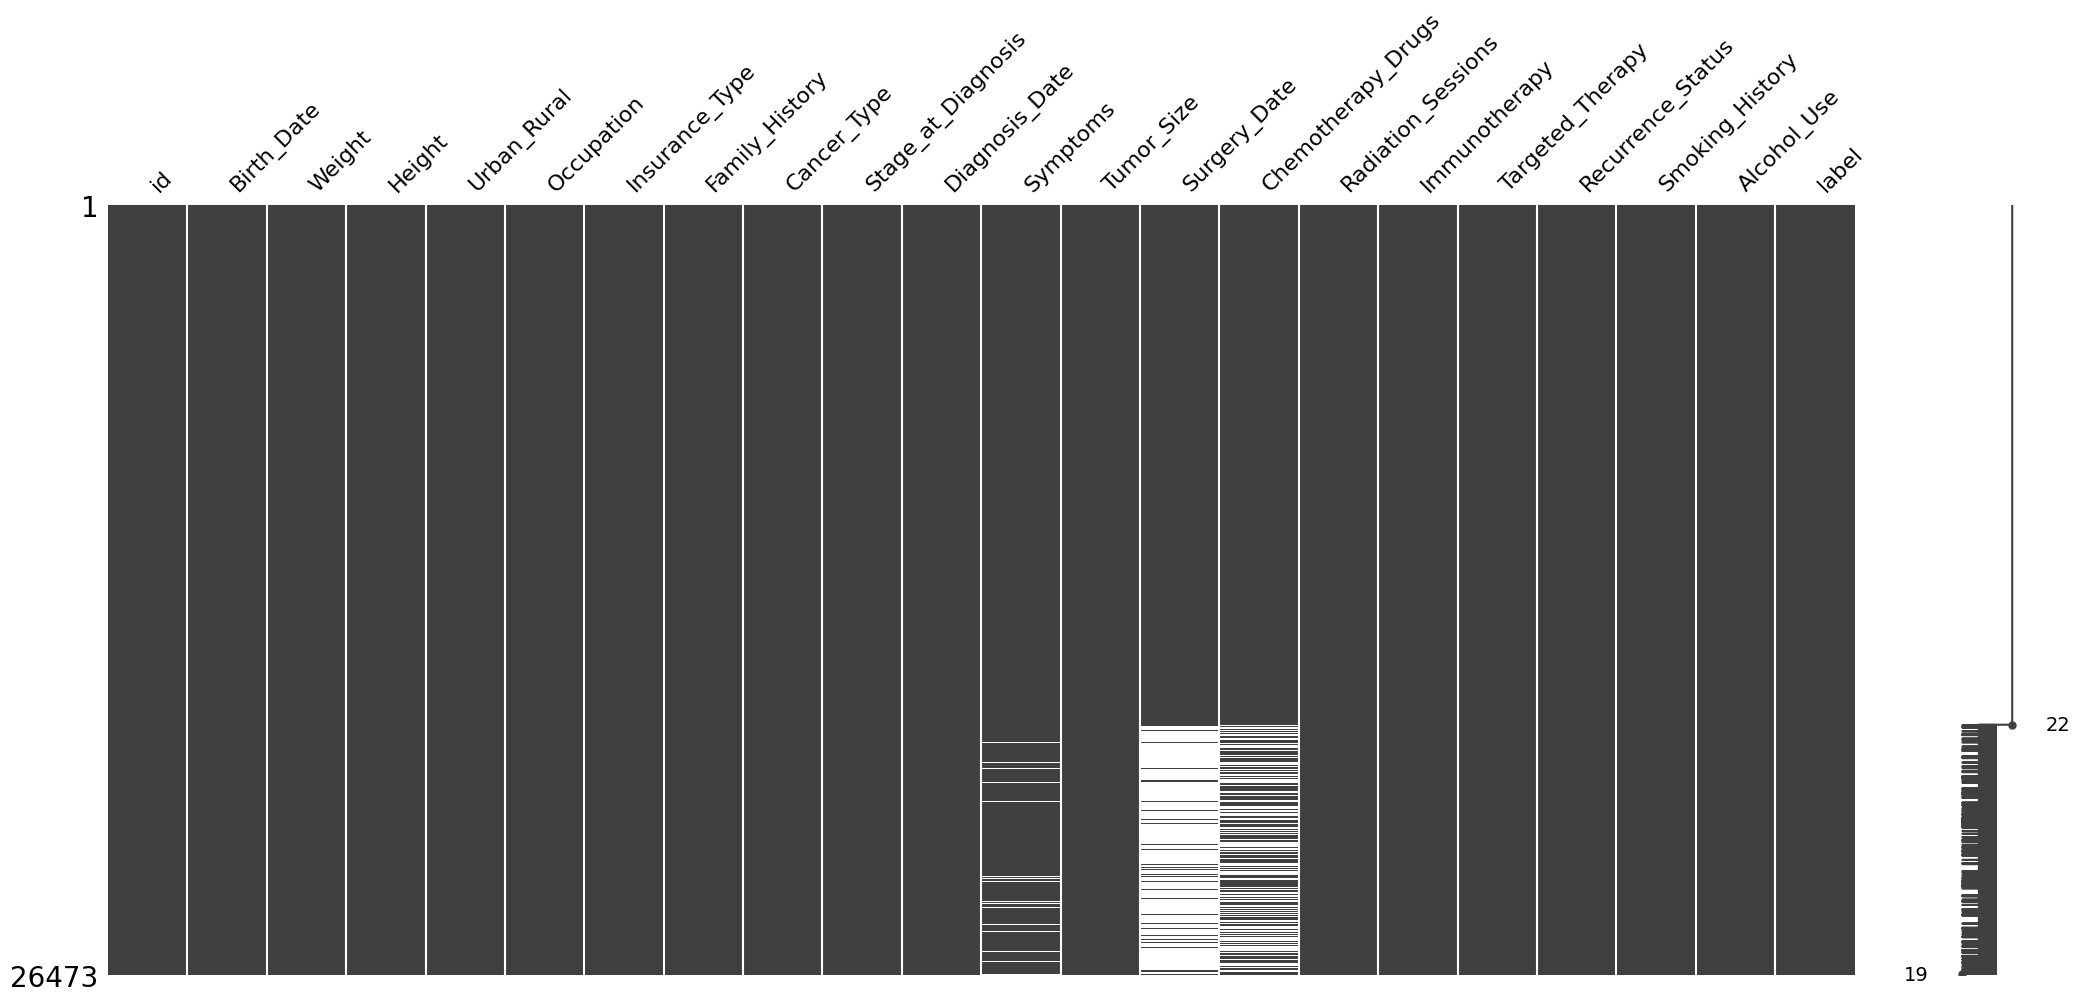

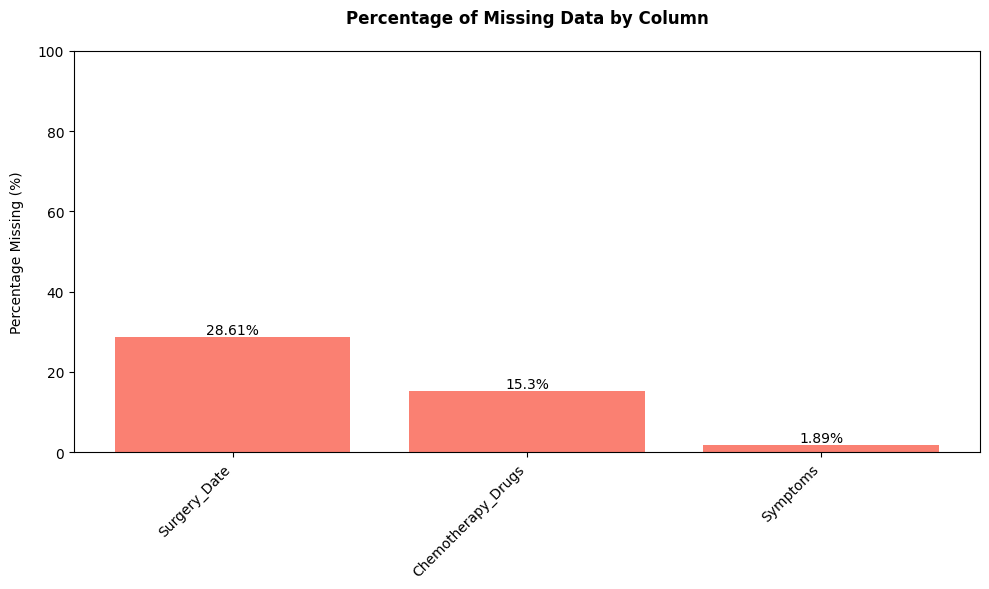

                    Missing Values  Percentage (%)
Surgery_Date                  7575           28.61
Chemotherapy_Drugs            4050           15.30
Symptoms                       501            1.89


In [2]:
msno.matrix(df)
plt.show()


def show_missing_data(df):
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100

    missing_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage (%)': missing_percent.round(2)
    })
    
    missing_df = missing_df[missing_df['Missing Values'] > 0]
    
    missing_df = missing_df.sort_values('Percentage (%)', ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(missing_df.index, missing_df['Percentage (%)'], color='salmon')
    plt.title('Percentage of Missing Data by Column', pad=20, weight='bold')
    plt.ylabel('Percentage Missing (%)', labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return missing_df

missing_stats = show_missing_data(df)
print(missing_stats)

#### <span style="color: #8F00FF;">**getting insights from NaN values** <br>
here we checked if there is an imbalance between groups that have NaN as their chemo or surgery value

In [3]:




# Check if surgery/chemo missingness relates to outcomes
print("rate of people who didnt have surgery and survived: ",df[df['Surgery_Date'].isna()]['label'].mean())  
print("rate of people who had surgery and survived",df[df['Surgery_Date'].notna()]['label'].mean()) 

print("rate of people who had chemo and survived: ",df[df['Chemotherapy_Drugs'].notna()]['label'].mean())


print("Stage distribution for patients WITH chemo: ")
print(df[df['Chemotherapy_Drugs'].notna()]['Stage_at_Diagnosis'].value_counts(normalize=True))

print("\nStage distribution for patients WITHOUT chemo:")
print(df[df['Chemotherapy_Drugs'].isna()]['Stage_at_Diagnosis'].value_counts(normalize=True))




rate of people who didnt have surgery and survived:  0.4778877887788779
rate of people who had surgery and survived 0.4888877129855011
rate of people who had chemo and survived:  0.4864201935512643
Stage distribution for patients WITH chemo: 
Stage_at_Diagnosis
II     0.263881
III    0.260402
IV     0.239174
I      0.236543
Name: proportion, dtype: float64

Stage distribution for patients WITHOUT chemo:
Stage_at_Diagnosis
III    0.299506
II     0.289877
IV     0.205679
I      0.204938
Name: proportion, dtype: float64


#### <span style="color: #8F00FF;">**replacing NaN value with something useful**:
- for both surgery date and chemo drugs added a bool columns that if they had surgery or chemo drugs at all
- filled NaN values in chemo drugs with None because there is an small percentage of NaN values in that column, also there is a good chance that some people didnt need chemo drugs
- if Symptom column is emoty lets assume  unkown for now. 


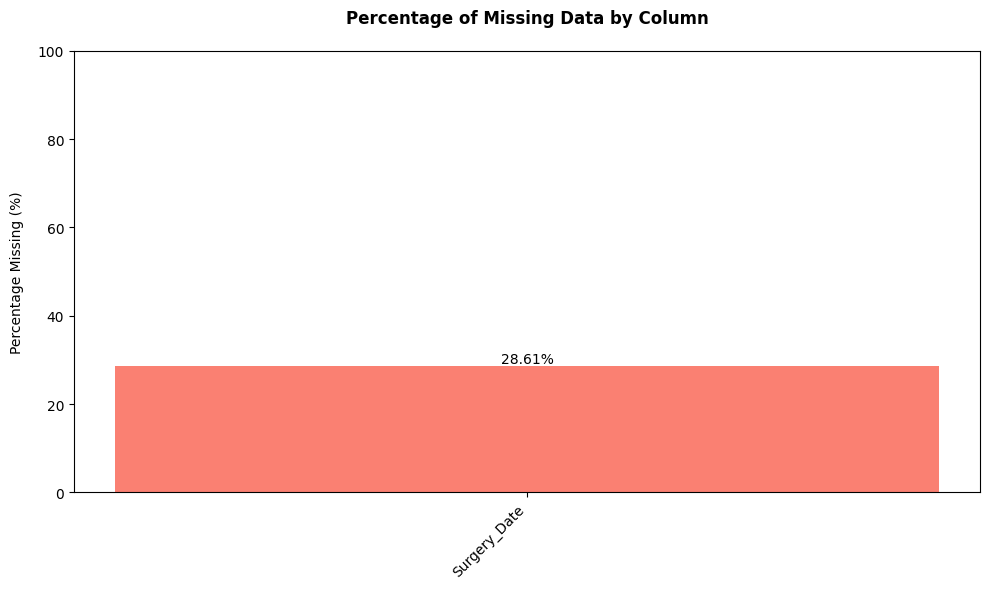

              Missing Values  Percentage (%)
Surgery_Date            7575           28.61


In [4]:

df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)

df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)



#NaN values here are  probably because they havent had chemo drugs
df['Chemotherapy_Drugs'] = df['Chemotherapy_Drugs'].fillna('None')


# set no symptoms to unknown for now
df['Symptoms'] = df['Symptoms'].fillna('Unknown')


# Calculate days from diagnosis to surgery (if surgery occurred)
df['Days_to_Surgery'] = (pd.to_datetime(df['Surgery_Date']) - pd.to_datetime(df['Diagnosis_Date'])).dt.days
df['Days_to_Surgery'] = df['Days_to_Surgery'].fillna(-1)  # -1 = no surgery
#maybe 100000 worked better


def surgery_timing(x):
    if x == -1:
        return 0  # No surgery
    elif x < 0:
        return 1  # Surgery before diagnosis
    elif x < 30:
        return 2  # Early surgery
    else:
        return 3  # Late surgery

df['Surgery_Timing'] = df['Days_to_Surgery'].apply(surgery_timing)
# tested this,wasnt useful

missing_stats = show_missing_data(df)
print(missing_stats)

### <span style="color: #8F00FF;">**fixing birthdates and surgery dates**: 
there were 87 entries were birthdates were 1800 , all of them were all.<br>
also there are 4000 entries where surgery date is before diagnosis. two versions of dataset where made in one surgery date is ignored and in the other rows with negative days to surgery is dropped. 

In [5]:
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer



# converting dates
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], errors='coerce')
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], errors='coerce')


# adding age when diagnosed
df['Age'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days // 365



#check out many people negative days to surgery values
print("Rows with negative days to surgery")
print(df[df['Days_to_Surgery'] < -1][['id', 'Diagnosis_Date', 'Surgery_Date', 'Days_to_Surgery',"label"]])

df = df[df['Birth_Date'].notna()]




df['Height'] = df['Height'].replace(r'[^\d.]', '', regex=True).astype(float)
df['Weight'] = df['Weight'].replace(r'[^\d.]', '', regex=True).astype(float)




#clean 1800 guys
df = df[(df['Age'] > 0) & (df['Age'] < 120)]


# print("\nAge distribution:")
# print(df['Age'].describe())





Rows with negative days to surgery
          id Diagnosis_Date Surgery_Date  Days_to_Surgery  label
9         10     2018-07-31   2013-12-19          -1685.0      0
14        15     2021-10-11   2021-05-11           -153.0      0
15        16     2023-12-21   2022-08-19           -489.0      1
16        17     2017-10-15   2011-09-17          -2220.0      1
19        20     2020-05-19   2018-02-18           -821.0      1
...      ...            ...          ...              ...    ...
25877  25878     2022-11-29   2022-07-28           -124.0      0
25879  25880     2018-09-07   2018-05-01           -129.0      0
25997  25998     2018-07-15   2018-06-29            -16.0      1
26069  26070     2019-05-28   2019-03-06            -83.0      1
26354  26355     2023-04-26   2023-04-22             -4.0      0

[4679 rows x 5 columns]



### <span style="color: #8F00FF;">**Basic Feature Engineering**: 




#### <span style="color: #8F00FF;">**adding  new feature**: 
 - BMI was calculated (and later checked using corr  matrix to see if it is worth keeping or not) <br>
 - count of drugs each person took was calculated. <br>
  - drugs were seprated  and one hot encoded properly. <br>
  - new flag were made from EDA(to seprate extreme cases) 


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

# BMI
df['BMI'] = df['Weight'] / (df['Height']/100)**2




df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(
    lambda x: 0 if x == 'None' else len(x.split(','))
)










df['Drugs_List'] = df['Chemotherapy_Drugs'].apply(
    lambda x: [drug.strip() for drug in x.split(',')] if x != 'None' else []
)
mlb = MultiLabelBinarizer()
drug_encoded = pd.DataFrame(
    mlb.fit_transform(df['Drugs_List']),
    columns=[f"Drug_{drug}" for drug in mlb.classes_],
    index=df.index
)
df = pd.concat([df, drug_encoded], axis=1)


df['Is_Factory_Worker'] = (df['Occupation'] == 'Factory Worker').astype(int)
df['Is_Early_Stage'] = df['Stage_at_Diagnosis'].isin(['I', 'II']).astype(int)
df['Is_Stage_IV'] = (df['Stage_at_Diagnosis'] == 'IV').astype(int)









# bs features dont try
# df['BMI_X_Stage'] = df['BMI'] * df['Stage_at_Diagnosis']
# df['Age_X_Stage'] = df['Age'] * df['Stage_at_Diagnosis']
# df['Is_Stage_IV_X_Factory'] = df['Is_Factory_Worker'] * (df['Stage_at_Diagnosis'] == 4).astype(int)
# df['Cancer_Deadliness'] = df['Cancer_Type'].map(cancer_survival)
# df['Treatment_Intensity'] = df['Radiation_Sessions'] * df['Drug_Count']
# df['Surgery_Response'] = df['Days_to_Surgery'].apply(
#     lambda x: 0 if x == -1 else (1 if x < 30 else 2)) 
# df['Performance_Score'] = (
#     df['Age']/10 + 
#     df['Stage_at_Diagnosis']*2 + 
#     (df['BMI'] < 18.5).astype(int)*3
# )














  
#### <span style="color: #8F00FF;">**encoding ordinals**:
 - ordinal features were encoded properly <br>

In [7]:

roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Stage_at_Diagnosis'] = df['Stage_at_Diagnosis'].str.extract(r'([IV]+)')[0].map(roman_to_int)







occupation_rank = {
    'Unemployed': 4,
    'Retired': 3,
    'Farmer': 2,
    'Office Worker': 1,
    'Factory Worker': 5
}

# occupation_rank = {
#     'Unemployed': 2,
#     'Retired': 5,
#     'Farmer': 4,
#     'Office Worker': 3,
#     'Factory Worker': 1
# }

# occupation_rank = {
#     'Unemployed': 2,
#     'Retired': 3,
#     'Farmer': 3,
#     'Office Worker': 2,
#     'Factory Worker': 1
# }









df['Occupation'] = df['Occupation'].map(occupation_rank).fillna(0).astype(int)



smoke_rank = {
    'Never': 1,
    'Former': 2,
    'Current': 3,
}
df['Smoking_History'] = df['Smoking_History'].map(smoke_rank).astype(int)



alcohol_rank = {
    'Never': 1,
    'Occasional': 2,
    'Regular': 3,
}
df['Alcohol_Use'] = df['Alcohol_Use'].map(alcohol_rank).astype(int)




cancer_rank = {
    'Lung': 1,
    'Esophageal': 2,
    'Stomach': 2,
    'Colorectal': 3,
    "Cervical":4,
    "Liver": 4,
    "Breast":5
}
df['Cancer_Type'] = df['Cancer_Type'].map(cancer_rank).astype(int)




  
#### <span style="color: #8F00FF;">**target encoding cancer types**:
 - from EDA we know cancers kinda have an order(basically like a deadliness order) <br>

In [8]:
cancer_target_means = df.groupby('Cancer_Type')['label'].mean().to_dict()
df['Cancer_Type_Encoded'] = df['Cancer_Type'].map(cancer_target_means)
print(cancer_target_means)

{1: 0.36116803278688525, 2: 0.44898230677131834, 3: 0.4708686440677966, 4: 0.540301908288237, 5: 0.589872810175186}


  
#### <span style="color: #8F00FF;">**encoding binaries**:
 - binary  features were encoded properly <br>

In [9]:
df['Urban_Rural'] = df['Urban_Rural'].str.lower().map({'urban': 1, 'rural': 0})
df['Family_History'] = df['Family_History'].str.lower().map({'yes': 1, 'no': 0})
df['Immunotherapy'] = df['Immunotherapy'].str.lower().map({'yes': 1, 'no': 0})
df['Targeted_Therapy'] = df['Targeted_Therapy'].str.lower().map({'yes': 1, 'no': 0})
df['Recurrence_Status'] = df['Recurrence_Status'].str.lower().map({'yes': 1, 'no': 0})

  
#### <span style="color: #8F00FF;">**checking the final preprocessed data**:

In [10]:

print(df.describe())
df_with_surgery = df.copy()

# df_with_surgery.head()
# df_with_surgery.hist(bins=50,figsize=(12,8))
# plt.show()


#since the test has the error of diagnosis date happening  after suregery date , it is better to not use this.
df_clean_surgery = df[df['Days_to_Surgery'] >= -1].copy()
# df_clean_surgery.describe()

                 id                     Birth_Date        Weight  \
count  26386.000000                          26386  26386.000000   
mean   13235.928977  1968-12-15 06:16:37.074206020     73.799598   
min        1.000000            1935-01-01 00:00:00     31.500000   
25%     6617.250000            1950-11-05 12:00:00     57.000000   
50%    13238.500000            1967-09-22 12:00:00     72.100000   
75%    19855.750000            1986-05-23 00:00:00     88.400000   
max    26473.000000            2007-12-27 00:00:00    133.100000   
std     7642.678012                            NaN     21.358527   

             Height   Urban_Rural    Occupation  Family_History   Cancer_Type  \
count  26386.000000  26386.000000  26386.000000    26386.000000  26386.000000   
mean     172.476427      0.538316      2.994618        0.425870      3.001175   
min      150.000000      0.000000      1.000000        0.000000      1.000000   
25%      161.000000      0.000000      2.000000        0.000000

## <span style="color: #8F00FF;">**Model training and evalution**:


### <span style="color: #8F00FF;">**Selecting Features**: 
here features are seprated and train test split is performed.

In [11]:

from sklearn.model_selection import train_test_split




# ordinal_features = [
#     'Stage_at_Diagnosis', 
#     'Occupation',        
#     'Cancer_Type',     
#     'Smoking_History',
#     'Alcohol_Use'
# ]

# # Nominal features (no inherent order)
# nominal_features = [
#     'Urban_Rural',
#     'Insurance_Type',
#     'Family_History',
#     'Had_Surgery',
#     'Had_Chemotherapy',
#     'Immunotherapy',
#     'Targeted_Therapy', 
#     'Recurrence_Status',
#     'Is_Factory_Worker',
#     'Is_Early_Stage',
    
# ] + list(drug_encoded.columns) 


# numerical_features = [
#     'Weight', 'Height', 'Age', 
#     'Radiation_Sessions', 'Tumor_Size', 'BMI',
#     'Days_to_Surgery'
# ]



ordinal_features = [
    'Stage_at_Diagnosis', 
    'Cancer_Type',     
    'Smoking_History',
    'Alcohol_Use'
]

nominal_features = [
    'Urban_Rural',
    'Insurance_Type',
    'Family_History',
    'Had_Surgery',    'Occupation',
    'Had_Chemotherapy',
    'Immunotherapy', 
    'Recurrence_Status',
    'Is_Factory_Worker',
    'Surgery_Timing'
    
] + list(drug_encoded.columns) 


numerical_features = [
    'Weight', 'Height', 'Age', 
    'Radiation_Sessions', 'Tumor_Size', 'BMI',
    'Days_to_Surgery'
    # 'Cancer_Type_Encoded'
]





y = df_with_surgery['label']






X = df_with_surgery[numerical_features +nominal_features+ordinal_features]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print("Class balance in train:", y_train.value_counts(normalize=True))






Train size: (21108, 33), Test size: (5278, 33)
Class balance in train: label
0    0.514307
1    0.485693
Name: proportion, dtype: float64



#### <span style="color: #8F00FF;">**checking corr matrix**: 
correlation matrix is plotted to see how features effect the outcome and drop features if needed. 
- it seems we cant drop any one of the features

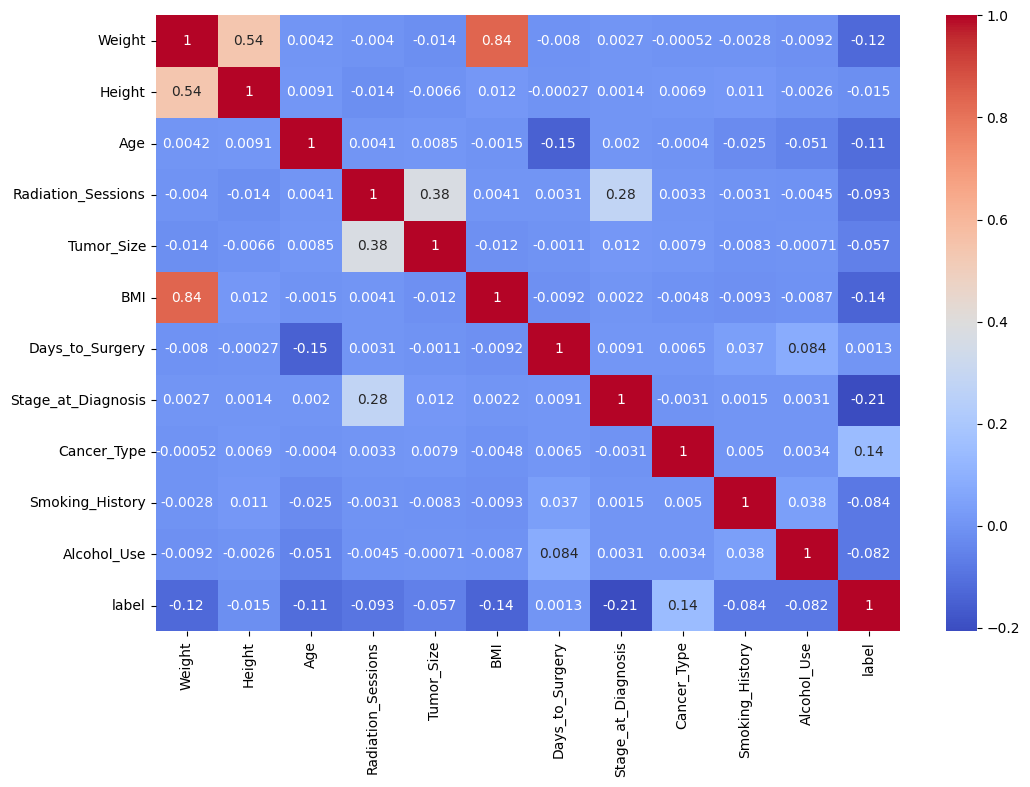

In [12]:

plt.figure(figsize=(12,8))
sns.heatmap((df_with_surgery[numerical_features+ordinal_features+["label"]]).corr(), annot=True, cmap='coolwarm')
plt.show()

#### <span style="color: #8F00FF;">**Applying column transfer:**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features+ordinal_features),
    ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)],
    remainder='passthrough'
)




#### <span style="color: #8F00FF;">**Creating piplines and testing:**

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score



##### <span style="color: #8F00FF;">**Logistic regression**

In [15]:
lr_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegressionCV(
        Cs=10,
        cv=5,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        scoring='roc_auc'
    ))
])

##### <span style="color: #8F00FF;">**XGBOOST**

In [16]:
xgb_model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        scale_pos_weight=sum(y_train==0)/sum(y_train==1),
        random_state=42,
        eval_metric='auc',
        learning_rate=0.009884850793730734,max_depth=8, n_estimators=445, subsample= 0.698567141638336, colsample_bytree= 0.9210776442460646, gamma=0.9999029437049183
    ))
])

##### <span style="color: #8F00FF;">**XGBOOST with random search**

In [17]:
param_dist = {
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.5, 0.5),
    'clf__gamma': uniform(0, 5)
}

search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

##### <span style="color: #8F00FF;">**XGBOOST with grid search**

In [18]:
xgb_params = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}


xgb_grid= GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)


##### <span style="color: #8F00FF;">**LGBM**

In [19]:
lgbm_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        metric='auc',
        n_estimators=200,
        max_depth=5
    ))
])

##### <span style="color: #8F00FF;">**Cat boost**

In [20]:

catboost_model = Pipeline([
    ('pre', preprocessor),
    ('clf', CatBoostClassifier(
        iterations=429,
        depth=9,
        learning_rate=0.01070956845958623,
        random_state=42,
        l2_leaf_reg= 0.164160631870976,
        border_count=200

    ))
])

##### <span style="color: #8F00FF;">**Random Forest**

In [21]:

rf_model = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight='balanced',
        random_state=42
    ))
])



=== Logistic Regression ===
Accuracy: 0.6588
ROC AUC: 0.7175
Precision: 0.6462
Recall: 0.6570
F1 Score: 0.6516
Confusion Matrix:
Predicted     0     1
Actual               
0          1793   922
1           879  1684


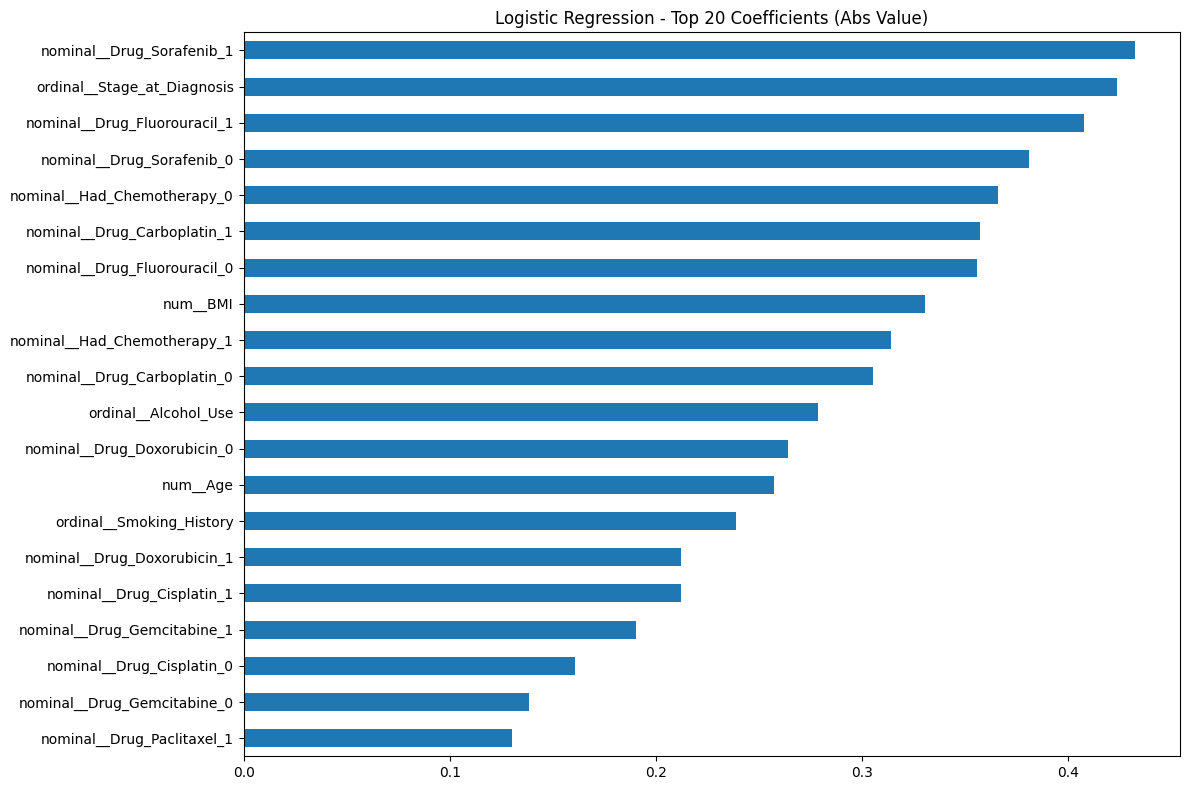


Top Coefficients:
nominal__Drug_Sorafenib_1       0.432854
ordinal__Stage_at_Diagnosis     0.424120
nominal__Drug_Fluorouracil_1    0.407915
nominal__Drug_Sorafenib_0       0.381016
nominal__Had_Chemotherapy_0     0.366000
nominal__Drug_Carboplatin_1     0.357270
nominal__Drug_Fluorouracil_0    0.356077
num__BMI                        0.330789
nominal__Had_Chemotherapy_1     0.314162
nominal__Drug_Carboplatin_0     0.305432
ordinal__Alcohol_Use            0.278984
nominal__Drug_Doxorubicin_0     0.264375
num__Age                        0.257445
ordinal__Smoking_History        0.238862
nominal__Drug_Doxorubicin_1     0.212537
nominal__Drug_Cisplatin_1       0.212526
nominal__Drug_Gemcitabine_1     0.190499
nominal__Drug_Cisplatin_0       0.160688
nominal__Drug_Gemcitabine_0     0.138661
nominal__Drug_Paclitaxel_1      0.130134

=== XGBoost ===
Accuracy: 0.8081
ROC AUC: 0.9074
Precision: 0.8020
Recall: 0.8030
F1 Score: 0.8025
Confusion Matrix:
Predicted     0     1
Actual               

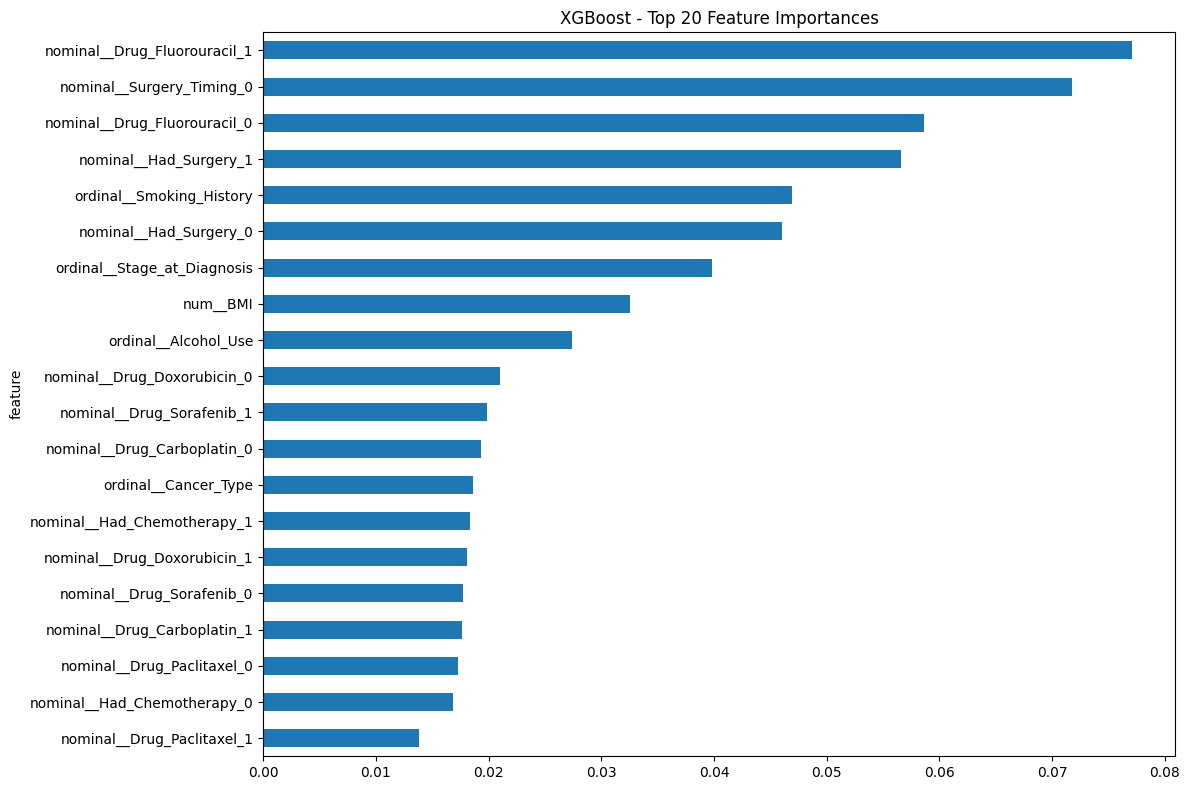


Top Best Features:
                     feature  importance
nominal__Drug_Fluorouracil_1    0.077064
   nominal__Surgery_Timing_0    0.071807
nominal__Drug_Fluorouracil_0    0.058591
      nominal__Had_Surgery_1    0.056568
    ordinal__Smoking_History    0.046919
      nominal__Had_Surgery_0    0.046054
 ordinal__Stage_at_Diagnosis    0.039826
                    num__BMI    0.032556
        ordinal__Alcohol_Use    0.027416
 nominal__Drug_Doxorubicin_0    0.021034
   nominal__Drug_Sorafenib_1    0.019864
 nominal__Drug_Carboplatin_0    0.019357
        ordinal__Cancer_Type    0.018601
 nominal__Had_Chemotherapy_1    0.018388
 nominal__Drug_Doxorubicin_1    0.018083
   nominal__Drug_Sorafenib_0    0.017719
 nominal__Drug_Carboplatin_1    0.017664
  nominal__Drug_Paclitaxel_0    0.017312
 nominal__Had_Chemotherapy_0    0.016802
  nominal__Drug_Paclitaxel_1    0.013844

Top Worst Features:
                         feature  importance
            num__Days_to_Surgery    0.006777
        

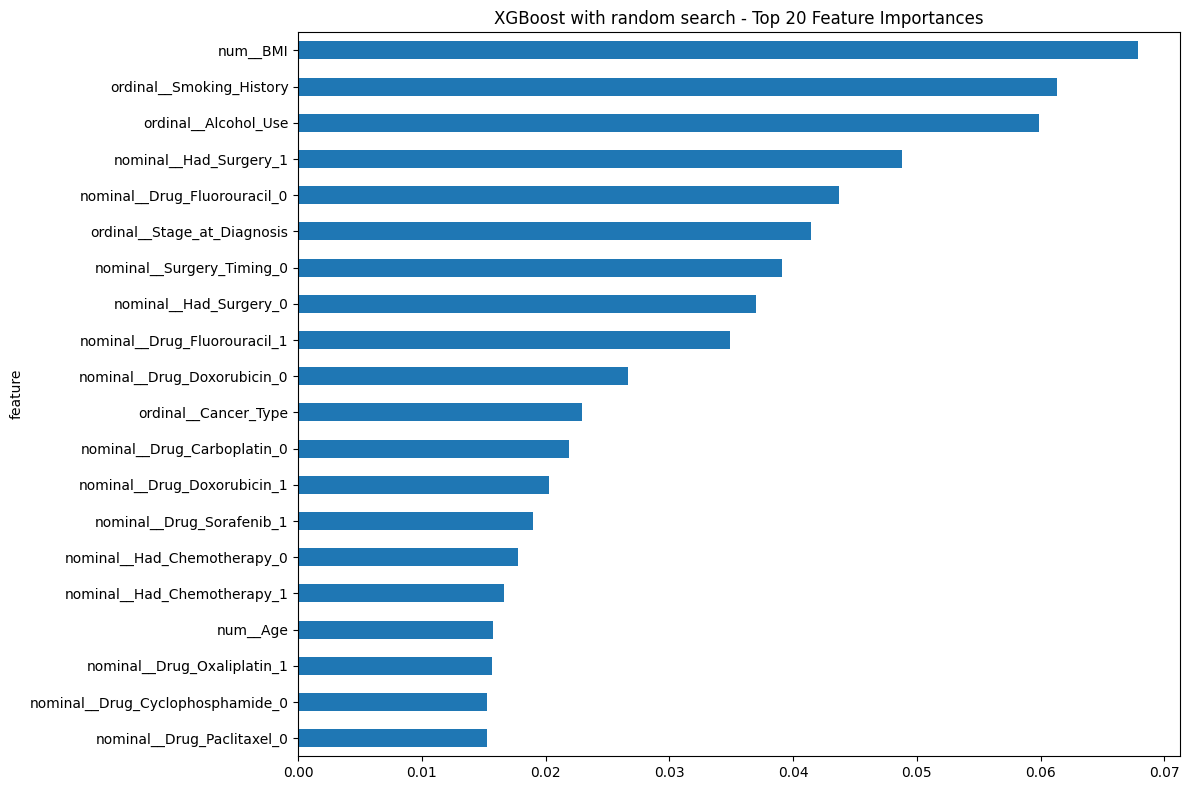


Top Best Features:
                         feature  importance
                        num__BMI    0.067874
        ordinal__Smoking_History    0.061306
            ordinal__Alcohol_Use    0.059831
          nominal__Had_Surgery_1    0.048772
    nominal__Drug_Fluorouracil_0    0.043731
     ordinal__Stage_at_Diagnosis    0.041453
       nominal__Surgery_Timing_0    0.039103
          nominal__Had_Surgery_0    0.037033
    nominal__Drug_Fluorouracil_1    0.034914
     nominal__Drug_Doxorubicin_0    0.026665
            ordinal__Cancer_Type    0.022927
     nominal__Drug_Carboplatin_0    0.021916
     nominal__Drug_Doxorubicin_1    0.020259
       nominal__Drug_Sorafenib_1    0.018969
     nominal__Had_Chemotherapy_0    0.017756
     nominal__Had_Chemotherapy_1    0.016620
                        num__Age    0.015728
     nominal__Drug_Oxaliplatin_1    0.015641
nominal__Drug_Cyclophosphamide_0    0.015272
      nominal__Drug_Paclitaxel_0    0.015270

Top Worst Features:
              

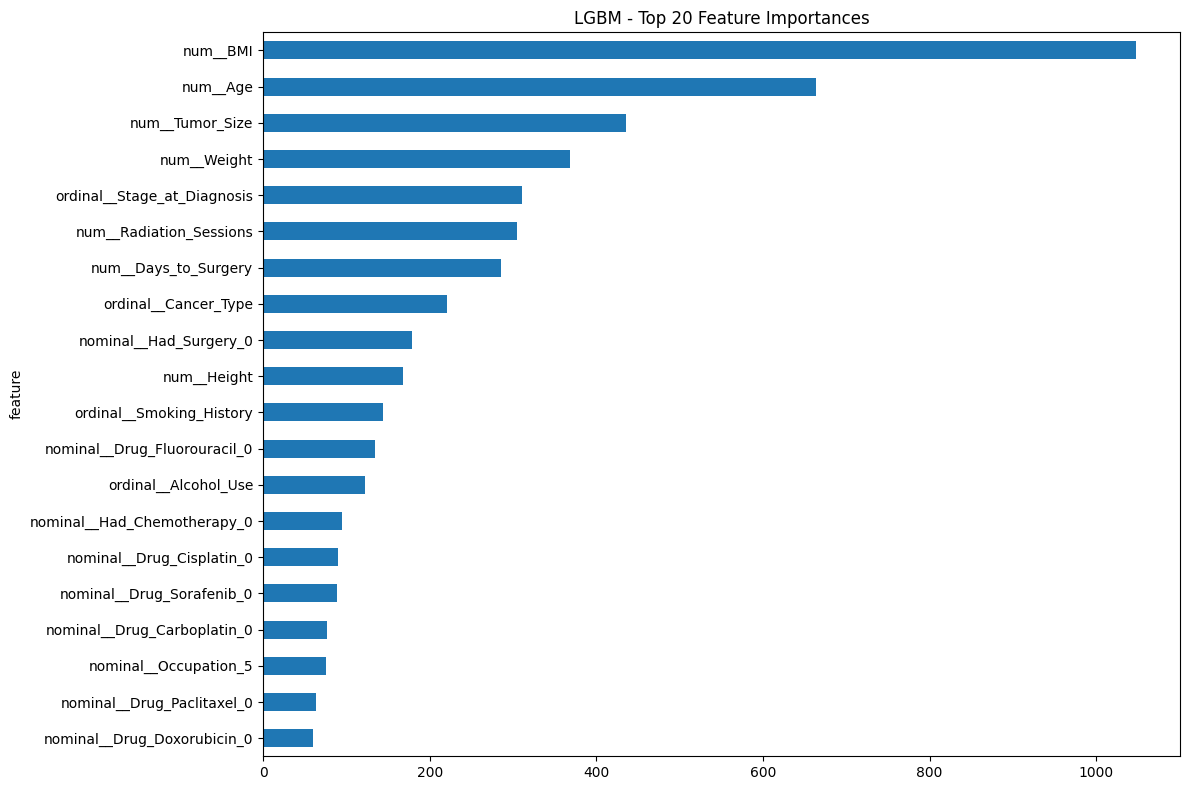


Top Best Features:
                     feature  importance
                    num__BMI        1048
                    num__Age         664
             num__Tumor_Size         436
                 num__Weight         368
 ordinal__Stage_at_Diagnosis         311
     num__Radiation_Sessions         305
        num__Days_to_Surgery         285
        ordinal__Cancer_Type         221
      nominal__Had_Surgery_0         179
                 num__Height         168
    ordinal__Smoking_History         144
nominal__Drug_Fluorouracil_0         134
        ordinal__Alcohol_Use         122
 nominal__Had_Chemotherapy_0          95
   nominal__Drug_Cisplatin_0          90
   nominal__Drug_Sorafenib_0          89
 nominal__Drug_Carboplatin_0          77
       nominal__Occupation_5          75
  nominal__Drug_Paclitaxel_0          64
 nominal__Drug_Doxorubicin_0          60

Top Worst Features:
                         feature  importance
      nominal__Drug_Paclitaxel_1           9
     nom

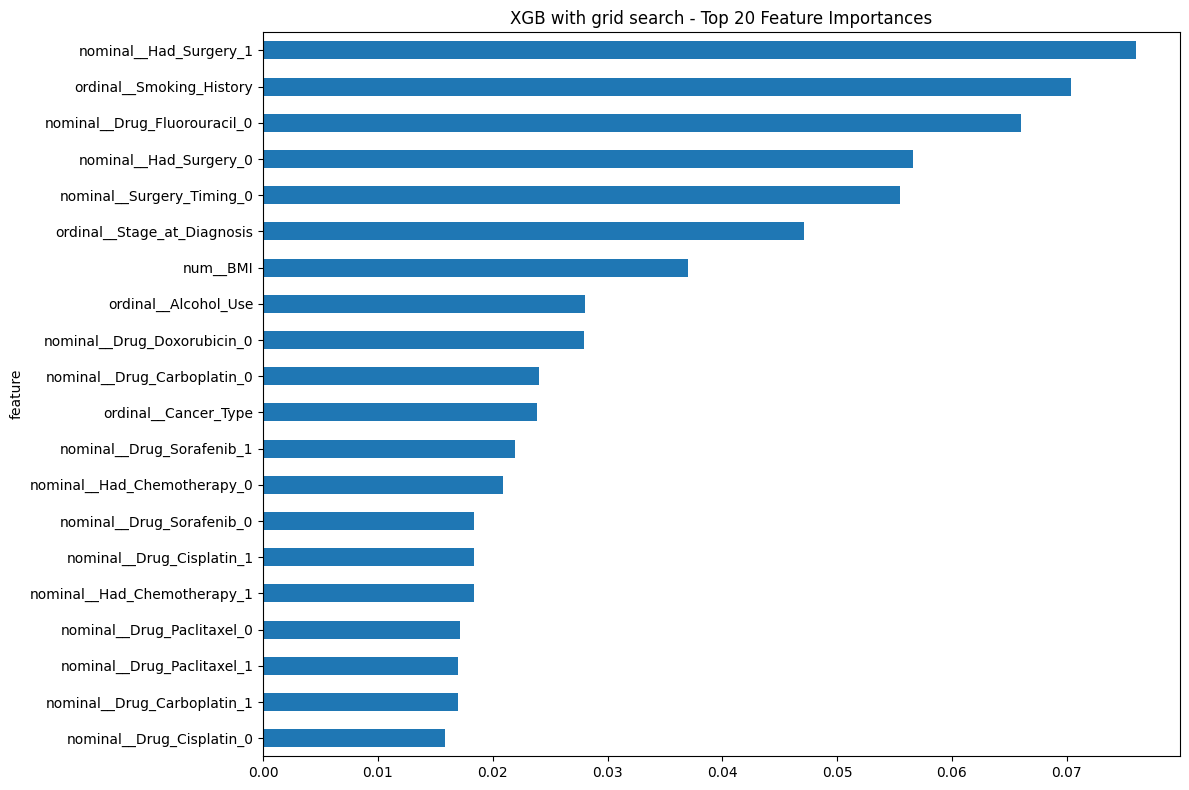


Top Best Features:
                     feature  importance
      nominal__Had_Surgery_1    0.076058
    ordinal__Smoking_History    0.070337
nominal__Drug_Fluorouracil_0    0.065987
      nominal__Had_Surgery_0    0.056572
   nominal__Surgery_Timing_0    0.055429
 ordinal__Stage_at_Diagnosis    0.047101
                    num__BMI    0.036995
        ordinal__Alcohol_Use    0.028007
 nominal__Drug_Doxorubicin_0    0.027943
 nominal__Drug_Carboplatin_0    0.024048
        ordinal__Cancer_Type    0.023839
   nominal__Drug_Sorafenib_1    0.021971
 nominal__Had_Chemotherapy_0    0.020877
   nominal__Drug_Sorafenib_0    0.018409
   nominal__Drug_Cisplatin_1    0.018377
 nominal__Had_Chemotherapy_1    0.018324
  nominal__Drug_Paclitaxel_0    0.017119
  nominal__Drug_Paclitaxel_1    0.017014
 nominal__Drug_Carboplatin_1    0.017005
   nominal__Drug_Cisplatin_0    0.015874

Top Worst Features:
                         feature  importance
                     num__Height    0.006019
       n

<Figure size 1200x800 with 0 Axes>

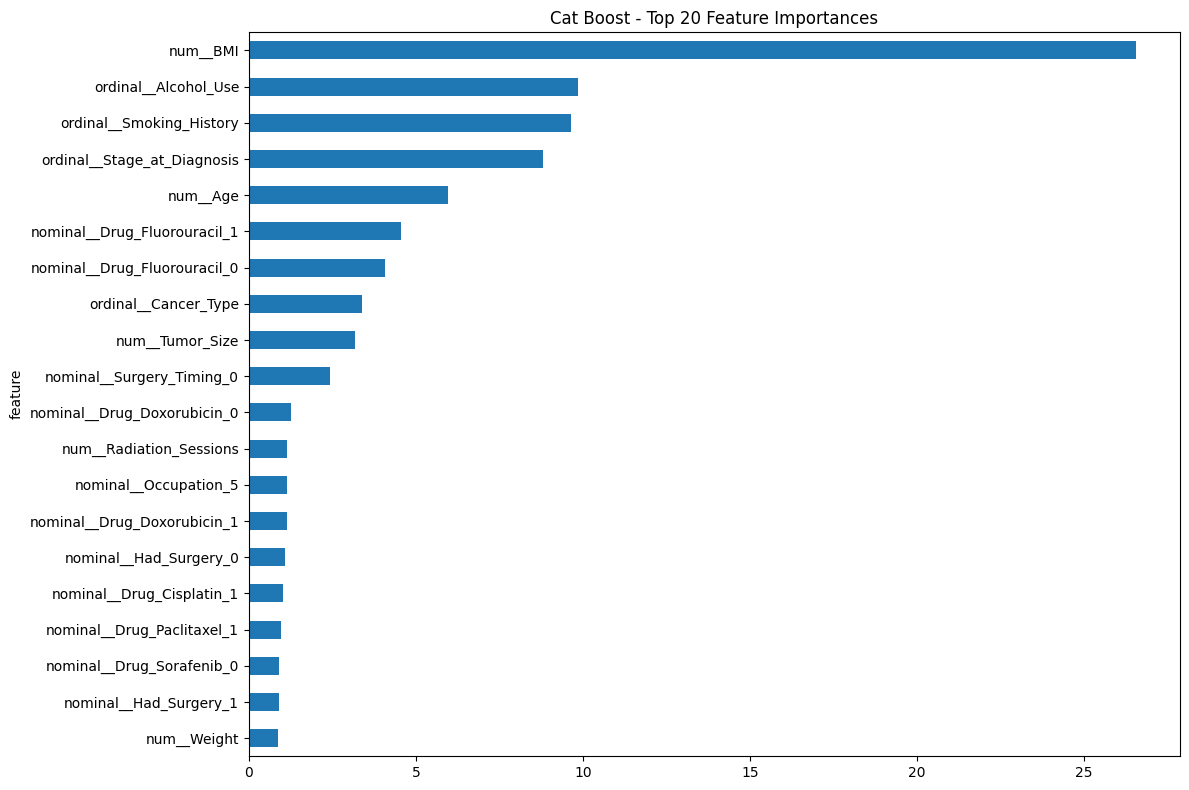


Top Best Features:
                     feature  importance
                    num__BMI   26.548958
        ordinal__Alcohol_Use    9.862123
    ordinal__Smoking_History    9.656758
 ordinal__Stage_at_Diagnosis    8.817998
                    num__Age    5.960238
nominal__Drug_Fluorouracil_1    4.565760
nominal__Drug_Fluorouracil_0    4.083661
        ordinal__Cancer_Type    3.395643
             num__Tumor_Size    3.175040
   nominal__Surgery_Timing_0    2.423756
 nominal__Drug_Doxorubicin_0    1.258233
     num__Radiation_Sessions    1.149149
       nominal__Occupation_5    1.143705
 nominal__Drug_Doxorubicin_1    1.129778
      nominal__Had_Surgery_0    1.080630
   nominal__Drug_Cisplatin_1    1.033393
  nominal__Drug_Paclitaxel_1    0.964728
   nominal__Drug_Sorafenib_0    0.904487
      nominal__Had_Surgery_1    0.891810
                 num__Weight    0.877603

Top Worst Features:
                         feature  importance
   nominal__Insurance_Type_NRCMS    0.133359
        

In [23]:
















models=[('Logistic Regression', lr_model),
        ('XGBoost', xgb_model),
        ('XGBoost with random search', search),
        ('LGBM',lgbm_model),
        ('XGB with grid search',xgb_grid),
        ('Random Forest',rf_model),
        ('Cat Boost',catboost_model)
        ]

# for name, model in models:
#     print(f"\n=== {name} ===")
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:, 1]
    
#     print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
#     print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
#     print("Confusion Matrix:")
#     print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
    
#     # Feature Importance (model-specific)
#     plt.figure(figsize=(12, 8))
    
#     if 'XGB' in name or 'Cat' in name or 'LGBM' in name:
#         # For tree-based models
#         if name == 'Cat Boost':
#             # CatBoost feature importance
#             importance = model.named_steps['clf'].get_feature_importance()
#             feature_names = model.named_steps['pre'].get_feature_names_out()
#             pd.Series(importance, index=feature_names).sort_values(ascending=False).head(20).plot.barh()
#         else:
#             # XGBoost/LightGBM
#             if name == 'XGBoost':
#                 xgb.plot_importance(model.named_steps['clf'], max_num_features=20)
#             elif name == 'LGBM':
#                 lgb.plot_importance(model.named_steps['clf'], max_num_features=20)
#         plt.title(f'{name} Feature Importance')
        
#     elif 'Logistic' in name:
#         # For logistic regression - show coefficients
#         coefs = pd.Series(
#             model.named_steps['clf'].coef_[0],
#             index=model.named_steps['pre'].get_feature_names_out()
#         ).sort_values(key=abs, ascending=False).head(20)
#         coefs.plot.barh()
#         plt.title('Logistic Regression Top Coefficients (Absolute Value)')
    
#     plt.tight_layout()
#     plt.show()
    

#     if 'XGB' in name or 'Cat' in name or 'LGBM' in name:
#         if name == 'Cat Boost':
#             importance = pd.DataFrame({
#                 'feature': model.named_steps['pre'].get_feature_names_out(),
#                 'importance': model.named_steps['clf'].get_feature_importance()
#             }).sort_values('importance', ascending=False)
#         # else:
#         #     importance = pd.DataFrame({
#         #         'feature': model.named_steps['clf'].feature_names_in_,
#         #         'importance': model.named_steps['clf'].feature_importances_
#         #     }).sort_values('importance', ascending=False)
        
#         print("\nTop best Features:")
#         print(importance.head(20))
#         print("\nTop worst Features:")
#         print(importance.tail(20))


for name, model in models:
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    print("Confusion Matrix:")
    print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

    # Extract pipeline if model is a search object
    pipeline = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    plt.figure(figsize=(12, 8))
    
    if 'XGB' in name or 'Cat' in name or 'LGBM' in name:
        feature_names = pipeline.named_steps['pre'].get_feature_names_out()
        
        if 'Cat' in name:
            importance = pipeline.named_steps['clf'].get_feature_importance()
        else:
            importance = pipeline.named_steps['clf'].feature_importances_

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values(by='importance', ascending=False)

        importance_df.head(20).set_index('feature')['importance'].plot.barh()
        plt.title(f'{name} - Top 20 Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("\nTop Best Features:")
        print(importance_df.head(20).to_string(index=False))
        print("\nTop Worst Features:")
        print(importance_df.tail(20).to_string(index=False))

    elif 'Logistic' in name:
        feature_names = pipeline.named_steps['pre'].get_feature_names_out()
        coefs = pd.Series(
            pipeline.named_steps['clf'].coef_[0],
            index=feature_names
        )
        top_coefs = coefs.abs().sort_values(ascending=False).head(20)

        top_coefs.plot.barh()
        plt.title(f'{name} - Top 20 Coefficients (Abs Value)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("\nTop Coefficients:")
        print(top_coefs.to_string())


#### <span style="color: #8F00FF;">**Optimizing XGBoost and CatBoost with optuna:**

##### <span style="color: #8F00FF;">**CatBoost**

In [25]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def objective(trial):
    params = {
        'clf__learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'clf__depth': trial.suggest_int('depth', 3, 15),
        'clf__iterations': trial.suggest_int('iterations', 50, 500),
        'clf__l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e5, log=True),
        'clf__border_count': trial.suggest_int('border_count', 32, 255)
    }
    
    model = Pipeline([
        ('pre', preprocessor),
        ('clf', CatBoostClassifier(
            scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
            random_state=42,
            eval_metric='AUC',
            verbose=False
        ))
    ])
    
    model.set_params(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

final_params = {f'clf__{key}': val for key, val in study.best_params.items()}


best_model = Pipeline([
    ('pre', preprocessor),
    ('clf', CatBoostClassifier(
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        random_state=42,
        eval_metric='AUC',
        verbose=False
    ))
])

best_model.set_params(**final_params)
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


[I 2025-05-13 18:46:19,511] A new study created in memory with name: no-name-2b56db6d-e296-4c23-85e5-77d5ede86326
[I 2025-05-13 18:46:23,884] Trial 0 finished with value: 0.8987256348691657 and parameters: {'learning_rate': 0.038421377292825874, 'depth': 8, 'iterations': 59, 'l2_leaf_reg': 2.882775507720842, 'border_count': 245}. Best is trial 0 with value: 0.8987256348691657.
[I 2025-05-13 18:46:32,497] Trial 1 finished with value: 0.7488571173949126 and parameters: {'learning_rate': 1.915002995116565e-05, 'depth': 3, 'iterations': 322, 'l2_leaf_reg': 24673.765915587024, 'border_count': 64}. Best is trial 0 with value: 0.8987256348691657.
[I 2025-05-13 18:48:07,317] Trial 2 finished with value: 0.8872273796710722 and parameters: {'learning_rate': 0.0002291721204286356, 'depth': 12, 'iterations': 281, 'l2_leaf_reg': 0.4169218049414354, 'border_count': 245}. Best is trial 0 with value: 0.8987256348691657.
[I 2025-05-13 18:48:28,040] Trial 3 finished with value: 0.8788615675426221 and pa

Best hyperparameters:  {'learning_rate': 0.023940198786768195, 'depth': 8, 'iterations': 328, 'l2_leaf_reg': 0.0026133902934382543, 'border_count': 241}
Test ROC AUC: 0.9065
Accuracy: 0.8069
Precision: 0.7896
Recall: 0.8213
F1 Score: 0.8051


##### <span style="color: #8F00FF;">**XGBoost**

In [26]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

def objective(trial):
    params = {
        'clf__learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'clf__max_depth': trial.suggest_int('max_depth', 3, 15),
        'clf__n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'clf__subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'clf__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'clf__gamma': trial.suggest_float('gamma', 0, 1),
    }

    model = Pipeline([
        ('pre', preprocessor),
        ('clf', XGBClassifier(
            scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
            random_state=42,
            eval_metric='auc',
            use_label_encoder=False
        ))
    ])

    model.set_params(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

xgb_best_params = {k.replace('clf__', ''): v for k, v in study.best_params.items()}

best_model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        random_state=42,
        eval_metric='auc',
        use_label_encoder=False,
        **xgb_best_params
    ))
])

best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


print(f"\nTest ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")




[I 2025-05-13 19:33:38,950] A new study created in memory with name: no-name-648bb51a-ebad-4d04-87ad-35d510080a33
[I 2025-05-13 19:34:18,684] Trial 0 finished with value: 0.903376358715288 and parameters: {'learning_rate': 0.006812494266937478, 'max_depth': 13, 'n_estimators': 470, 'subsample': 0.5773789173675721, 'colsample_bytree': 0.8839771421291224, 'gamma': 0.0261215794716807}. Best is trial 0 with value: 0.903376358715288.
[I 2025-05-13 19:34:23,188] Trial 1 finished with value: 0.8962320919460323 and parameters: {'learning_rate': 0.014089472836708215, 'max_depth': 7, 'n_estimators': 190, 'subsample': 0.6237242146428923, 'colsample_bytree': 0.5700868108980691, 'gamma': 0.2606419879919434}. Best is trial 0 with value: 0.903376358715288.
[I 2025-05-13 19:34:27,699] Trial 2 finished with value: 0.8885527602164067 and parameters: {'learning_rate': 0.0031174659208095977, 'max_depth': 7, 'n_estimators': 161, 'subsample': 0.8271343187346145, 'colsample_bytree': 0.7972058768057939, 'gamm

Best hyperparameters: {'learning_rate': 0.030939153997884737, 'max_depth': 6, 'n_estimators': 382, 'subsample': 0.7701175752631109, 'colsample_bytree': 0.9181391152871354, 'gamma': 0.20960517802743733}

Test ROC AUC: 0.9068
Test Accuracy: 0.8100
Precision: 0.8028
Recall: 0.8069
F1 Score: 0.8048


## <span style="color: #8F00FF;">**Testing real data**:
- it seems cat boost yileds the best results

In [24]:

test_df = pd.read_csv('content/cancer_patients/test_data.csv')

def preprocess_data(df):
    df = df.copy()
    
    df['Symptoms'] = df['Symptoms'].fillna('Unknown')
    df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)
    df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)
    df['Chemotherapy_Drugs'] = df['Chemotherapy_Drugs'].fillna('None')
    df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(
    lambda x: 0 if x == 'None' else len(x.split(','))
)
    df['Weight'] = pd.to_numeric(df['Weight'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
    df['Height'] = pd.to_numeric(df['Height'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
    
    df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], errors='coerce')
    df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], errors='coerce')
    df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], errors='coerce')
    
    df['Age'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days // 365
    df['Days_to_Surgery'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days
    df['Days_to_Surgery'] = df['Days_to_Surgery'].fillna(100000)
    
    df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
    
    
    df['Is_Early_Stage'] = df['Stage_at_Diagnosis'].isin(['I', 'II']).astype(int)
    
    roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
    df['Stage_at_Diagnosis'] = df['Stage_at_Diagnosis'].str.extract(r'([IV]+)')[0].map(roman_to_int)
    



    df['Is_Factory_Worker'] = (df['Occupation'] == 'Factory Worker').astype(int)


    occupation_rank = {
        'Unemployed': 4, 'Retired': 3, 'Farmer': 2, 
        'Office Worker': 1, 'Factory Worker': 5
    }
    df['Occupation'] = df['Occupation'].map(occupation_rank).fillna(0).astype(int)
    



    smoke_rank = {'Never': 1, 'Former': 2, 'Current': 3}
    df['Smoking_History'] = df['Smoking_History'].map(smoke_rank).astype(int)
    
    alcohol_rank = {'Never': 1, 'Occasional': 2, 'Regular': 3}
    df['Alcohol_Use'] = df['Alcohol_Use'].map(alcohol_rank).astype(int)


    df['Cancer_Type_Encoded'] = df['Cancer_Type'].map(cancer_target_means)
    print(cancer_target_means)
    cancer_rank = {
        'Lung': 1, 'Esophageal': 2, 'Stomach': 2, 
        'Colorectal': 3, "Cervical":4, "Liver": 4, "Breast":5
    }
    df['Cancer_Type'] = df['Cancer_Type'].map(cancer_rank).astype(int)
    
    binary_cols = ['Urban_Rural', 'Family_History', 'Immunotherapy', 'Targeted_Therapy', 'Recurrence_Status']
    for col in binary_cols:
        df[col] = df[col].str.lower().map({'yes': 1, 'no': 0, 'urban': 1, 'rural': 0}).fillna(0)
    
    df['Drugs_List'] = df['Chemotherapy_Drugs'].apply(
        lambda x: [drug.strip() for drug in x.split(',')] if x != 'None' else []
    )
    drug_encoded_df = pd.DataFrame(
        mlb.transform(df['Drugs_List']),
        columns=[f"Drug_{drug}" for drug in mlb.classes_],
        index=df.index
    )

    df['Surgery_Timing'] = df['Days_to_Surgery'].apply(surgery_timing)


    df['Treatment_Intensity'] = df['Radiation_Sessions'] * df['Drug_Count']
    df['Surgery_Response'] = df['Days_to_Surgery'].apply(
        lambda x: 0 if x == -1 else (1 if x < 30 else 2))  
    df['Performance_Score'] = (
        df['Age']/10 + 
        df['Stage_at_Diagnosis']*2 + 
        (df['BMI'] < 18.5).astype(int)*3
    )
    
    return pd.concat([df.drop(['Chemotherapy_Drugs', 'Drugs_List'], axis=1), drug_encoded_df], axis=1)




test_df_processed = preprocess_data(test_df)
X_test_real = test_df_processed[numerical_features + ordinal_features + nominal_features]


catboost_model.fit(X, y)

submission = pd.DataFrame({
    'id': test_df['id'],
    'label':catboost_model.predict(X_test_real)
})
submission.to_csv('submission.csv', index=False)
print("Submission created successfully!")

{1: 0.36116803278688525, 2: 0.44898230677131834, 3: 0.4708686440677966, 4: 0.540301908288237, 5: 0.589872810175186}
0:	learn: 0.6848150	total: 40.5ms	remaining: 17.3s
1:	learn: 0.6752825	total: 66ms	remaining: 14.1s
2:	learn: 0.6684291	total: 92.8ms	remaining: 13.2s
3:	learn: 0.6616138	total: 120ms	remaining: 12.7s
4:	learn: 0.6554648	total: 147ms	remaining: 12.4s
5:	learn: 0.6490515	total: 174ms	remaining: 12.3s
6:	learn: 0.6425688	total: 201ms	remaining: 12.1s
7:	learn: 0.6361108	total: 228ms	remaining: 12s
8:	learn: 0.6305644	total: 255ms	remaining: 11.9s
9:	learn: 0.6249882	total: 279ms	remaining: 11.7s
10:	learn: 0.6195172	total: 308ms	remaining: 11.7s
11:	learn: 0.6151007	total: 334ms	remaining: 11.6s
12:	learn: 0.6101566	total: 363ms	remaining: 11.6s
13:	learn: 0.6045028	total: 390ms	remaining: 11.5s
14:	learn: 0.6011551	total: 414ms	remaining: 11.4s
15:	learn: 0.5949651	total: 438ms	remaining: 11.3s
16:	learn: 0.5906536	total: 465ms	remaining: 11.3s
17:	learn: 0.5857987	total: 